### Try this notebook in Google Colab, Binder or SageMaker!


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/InsightSoftwareConsortium/itkwidgets/blob/main/examples/integrations/itk/SelectROI.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/InsightSoftwareConsortium/itkwidgets/HEAD?labpath=examples%2Fintegrations%2Fitk%2FSelectROI.ipynb)
[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github.com/InsightSoftwareConsortium/itkwidgets/blob/main/examples/integrations/itk/SelectROI.ipynb)

In [1]:
# Install dependencies for this example
import sys

!{sys.executable} -m pip install -q pooch tqdm "itk-io>=5.3.0" "itkwidgets[all]>=1.0a40"

In [2]:
import itk
import pooch
from ngff_zarr import ngff_image_to_itk_image
from itkwidgets import view
import zarr

In [3]:
file_name = pooch.retrieve('https://data.kitware.com/api/v1/file/564a5b078d777f7522dbfaa6/download',
                           fname='005_32months_T2_RegT1_Reg2Atlas_ManualBrainMask_Stripped.nrrd',
                           known_hash='a4a5739d5484f48653404763f807ff2b0e1900209cce029d912c2f92797207b6',
                           progressbar=True)

In [4]:
image = itk.imread(file_name)


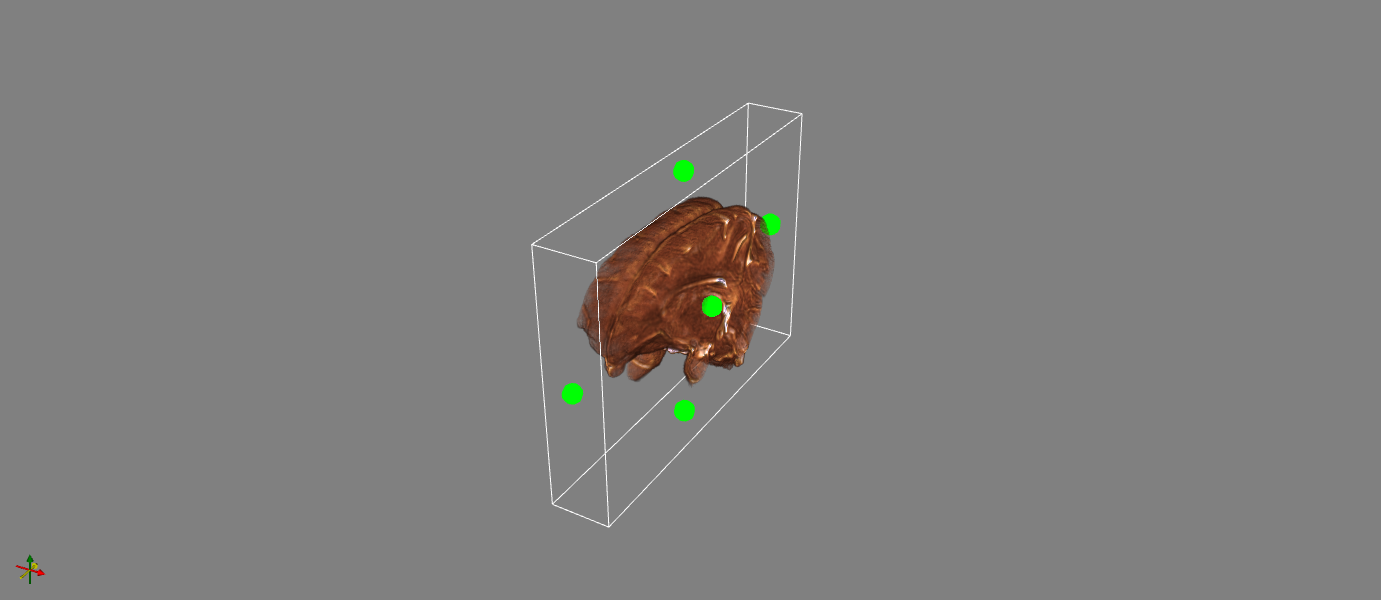
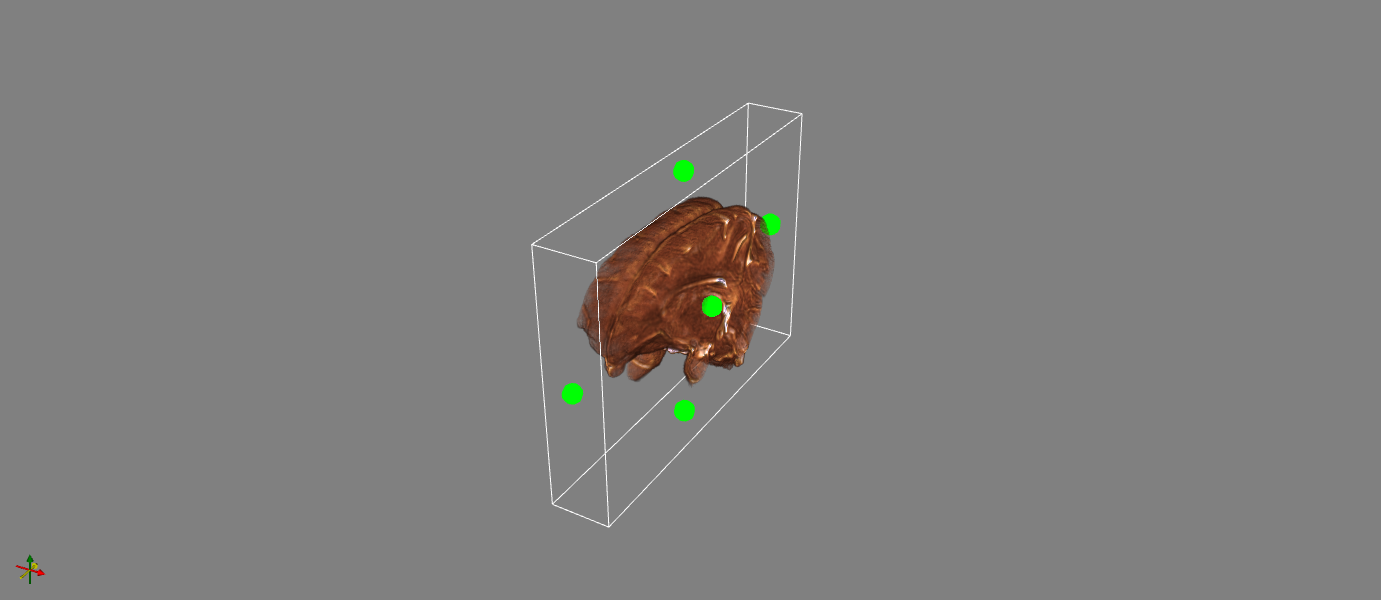

<IPython.core.display.Javascript object>

In [5]:
viewer = view(image)

#### Use the cropping planes to select the region of interest, then run the following cells

<img src="https://raw.githubusercontent.com/InsightSoftwareConsortium/itkwidgets/main/examples/integrations/itk/select_roi.gif" style="margin:auto"/>

#### There will be one or more resolution scales available depending on the size of the data. The lower the scale the higher the resolution, with zero being the highest resolution.

In [6]:
# Find the scale that we currently have loaded
loaded_scale = viewer.get_current_scale()

In [7]:
loaded_scale

0

#### By default the information for the current scale is returned when requesting the ROI slices. You can also pass a value in to explicitly request a scale.

In [8]:
# Request the slice information for the ROI
default_roi_slices = viewer.get_roi_slice()
roi_slices = viewer.get_roi_slice(loaded_scale)

#### The results should match!
#### *Note*: The data is streamed in in chunks and the current resolution will improve as each scale becomes available. If you find that the slices do not match check the currently loaded scale (either programmatically or with the UI) - it may have improved since you last checked!

In [9]:
# The results should match
print(f'Slices for loaded scale:       {roi_slices}')
print(f'Slices with default parameter: {default_roi_slices}')

Slices for loaded scale:       (slice(0, 250, None), slice(0, 350, None), slice(122, 170, None))
Slices with default parameter: (slice(0, 250, None), slice(0, 350, None), slice(122, 170, None))


#### The ROI region will return the physical, world coordinates for the selection

In [10]:
# Get the selected region for the current level
roi_region = viewer.get_roi_region()

In [11]:
roi_region

[{'x': 26.70976023219073, 'y': -6.971699714660643, 'z': -6.971699953079224},
 {'x': 39.35382616126007, 'y': 88.71824073791504, 'z': 61.378257513046265}]

In [12]:
# get_roi_image will return an ngff image for the currently selected image
# optionally a name can also be passed in to select a specific image if more than one image or label is loaded
roi_image = viewer.get_roi_image(loaded_scale)

In [13]:
roi_image

NgffImage(data=dask.array<getitem, shape=(250, 350, 48), dtype=int16, chunksize=(128, 128, 42), chunktype=numpy.ndarray>, dims=['z', 'y', 'x'], scale={'z': 0.2734, 'y': 0.2734, 'x': 0.2734}, translation={'x': 26.70976023219073, 'y': -6.971699714660643, 'z': -6.971699953079224}, name='Image', axes_units={'z': None, 'y': None, 'x': None}, computed_callbacks=[])

In [14]:
# Optionally we can also grab the ngff images for all scales
roi_multiscales = viewer.get_roi_multiscale()

In [15]:
roi_multiscales

Multiscales(images=[NgffImage(data=dask.array<rechunk-merge, shape=(250, 350, 48), dtype=int16, chunksize=(128, 128, 48), chunktype=numpy.ndarray>, dims=['z', 'y', 'x'], scale={'z': 0.2734, 'y': 0.2734, 'x': 0.2734}, translation={'x': 26.70976023219073, 'y': -6.971699714660643, 'z': -6.971699953079224}, name='Image', axes_units={'z': None, 'y': None, 'x': None}, computed_callbacks=[]), NgffImage(data=dask.array<rechunk-merge, shape=(250, 175, 48), dtype=int16, chunksize=(128, 128, 48), chunktype=numpy.ndarray>, dims=['z', 'y', 'x'], scale={'z': 0.2734, 'y': 0.5468, 'x': 0.2734}, translation={'z': -6.971699953079224, 'y': -6.8349997146606425, 'x': 26.70976023219073}, name='image', axes_units=None, computed_callbacks=[])], metadata=Metadata(axes=[Axis(name='z', type='space', unit=None), Axis(name='y', type='space', unit=None), Axis(name='x', type='space', unit=None)], datasets=[Dataset(path='scale0/Image', coordinateTransformations=[Scale(scale=[0.2734, 0.2734, 0.2734], type='scale'), Tr


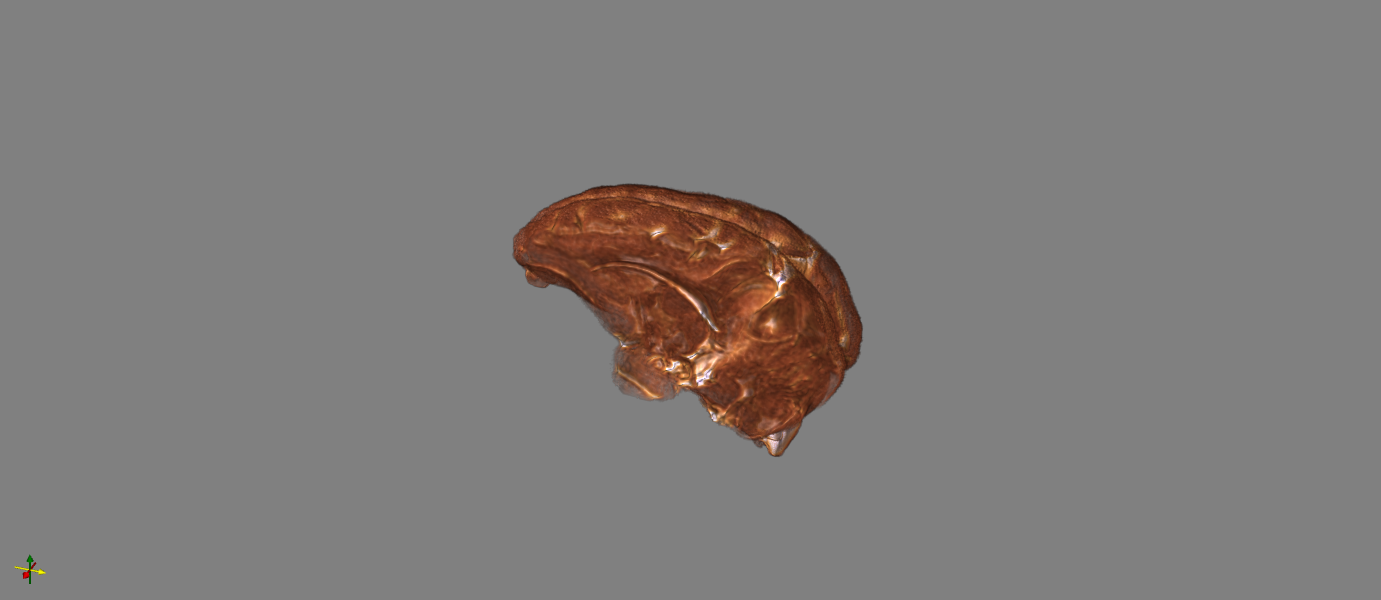
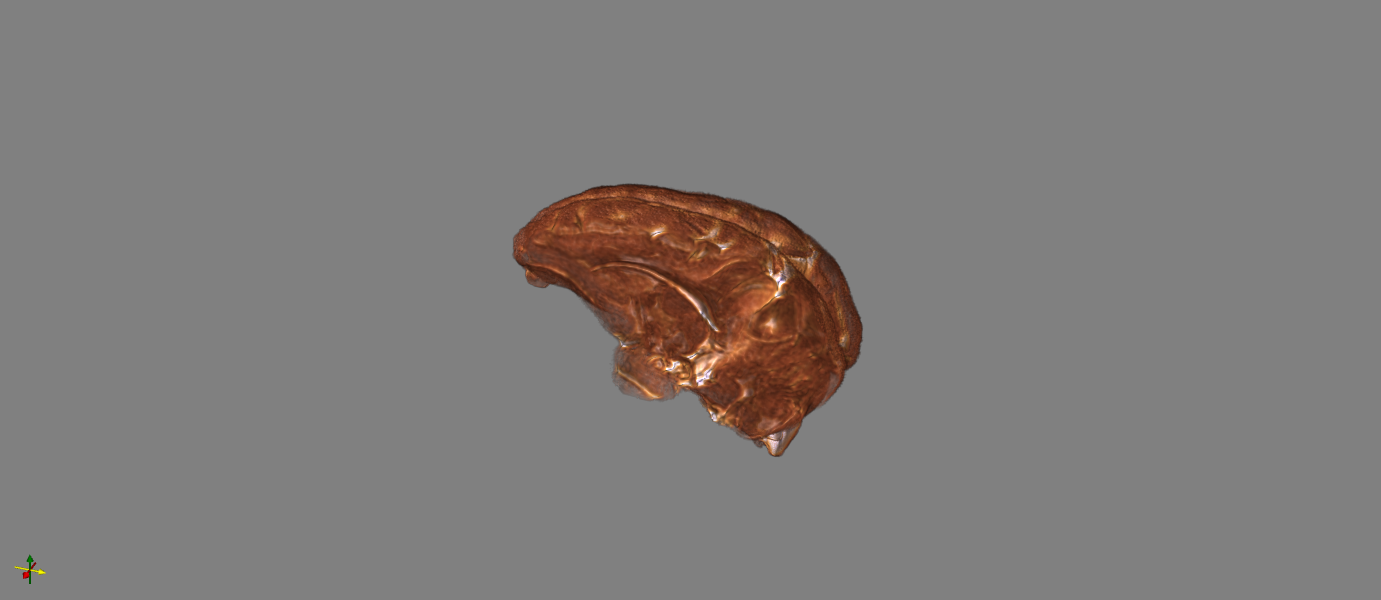

<IPython.core.display.Javascript object>

In [16]:
# Create a new viewer using only the data in the ROI determined above
viewer2 = view(roi_multiscales, rotate=True)

Extract the region from the original image. 

Use physical units, which are independent of resolutions, slices


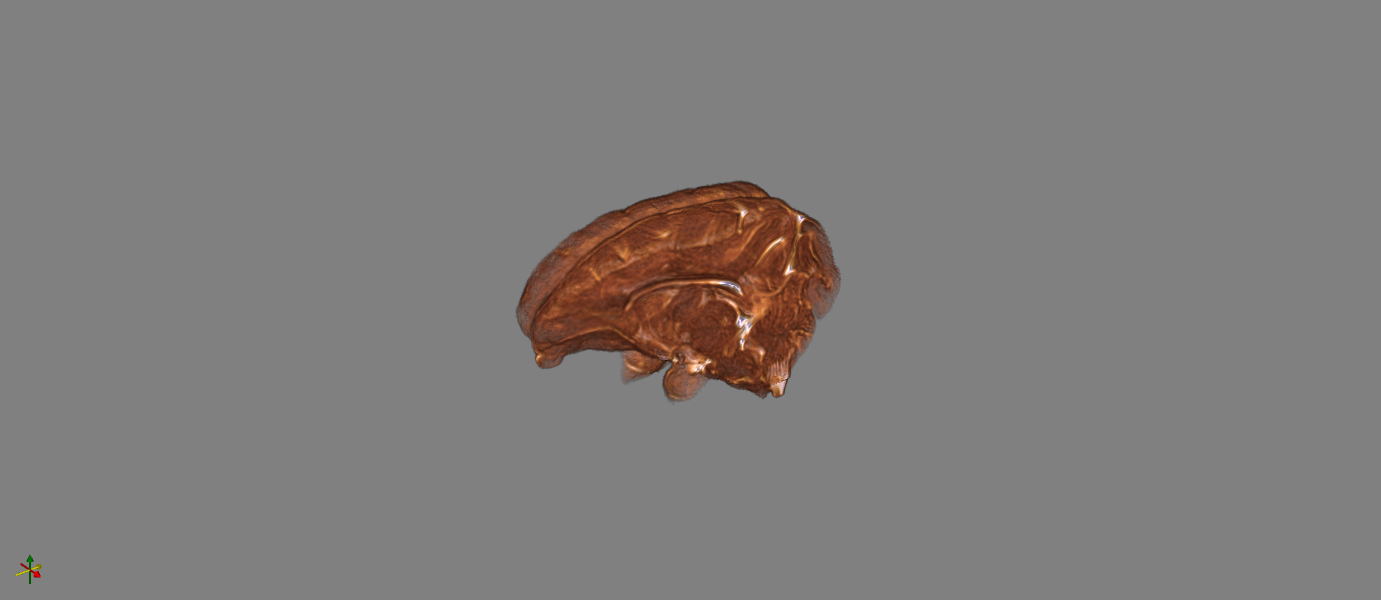
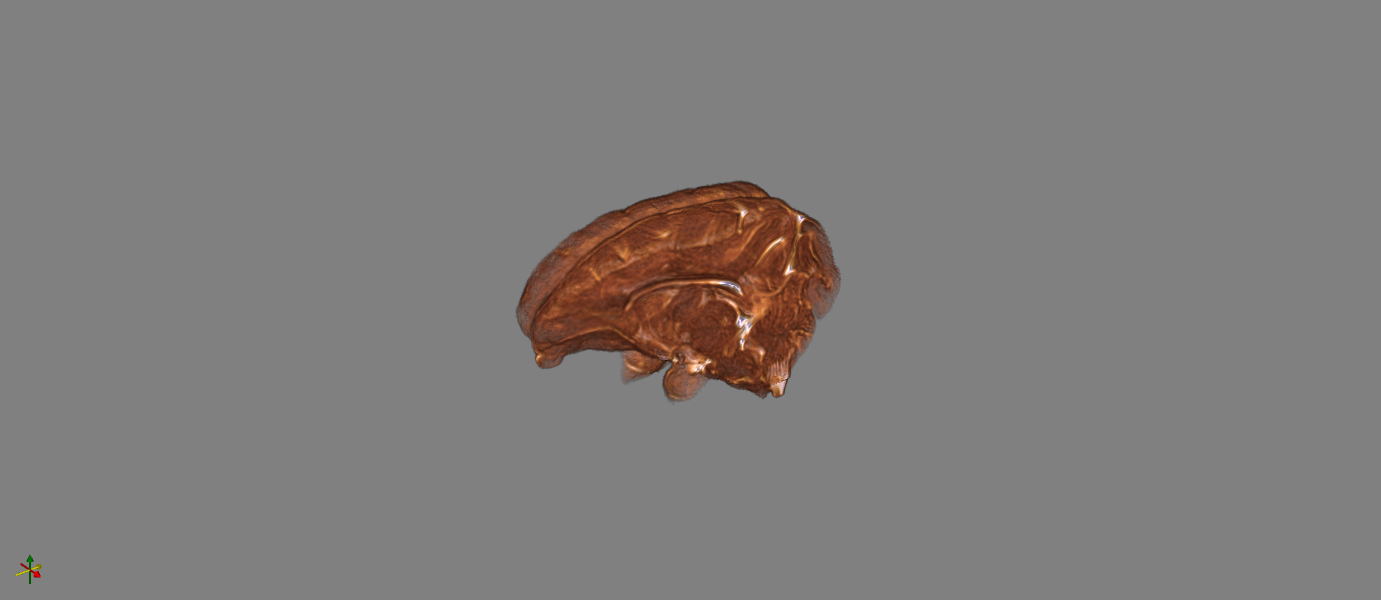

<IPython.core.display.Javascript object>

In [17]:
start_index = image.TransformPhysicalPointToIndex([roi_region[0]['x'], roi_region[0]['y'], roi_region[0]['z']])
size = image.TransformPhysicalPointToIndex([roi_region[1]['x'], roi_region[1]['y'], roi_region[1]['z']]) - start_index
extraction_region = itk.ImageRegion[3](start_index, size)

roi_image = itk.extract_image_filter(image, extraction_region=extraction_region)

viewer3 = view(roi_image, rotate=True)